In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import random
from torch import nn, optim
import torch.nn.functional as F

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

# Load Data

In [89]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        
    traj_min = np.min(inputs, axis = (1), keepdims = True)
    traj_max = np.max(inputs, axis = (1), keepdims = True)
    normal_inputs = (inputs - traj_min)/(traj_max - traj_min)
    
    normal_targets = None
    if split=="train" or split == 'val':
        normal_targets = (outputs - traj_min)/(traj_max - traj_min)
    
    return normal_inputs, normal_targets, traj_min, traj_max

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs, self.traj_min, self.traj_max = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx], self.traj_min[idx], self.traj_max[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

In [90]:
# intialize a dataset
def get_data_loader(city = 'austin', batch_size = 20):
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    val_dataset = ArgoverseDataset(city = city, split = 'val')

    train_loader = DataLoader(train_dataset,batch_size=batch_size)
    val_loader = DataLoader(val_dataset,batch_size=batch_size)
    return train_dataset, val_dataset, train_loader, val_loader

In [91]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 64)
len(val_dataset)

8609

In [92]:
len(train_dataset)

34432

In [93]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Model

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim, out_dim, hidden_dim):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(), 
            nn.Linear(hidden_dim, out_dim) #out_dim = 60*2
        )
        
    def forward(self, x, output_steps=60): 
        x = x.reshape(x.shape[0], -1)
        outputs = []
        
        for i in range(output_steps):
            out = self.model(x)    
            outputs.append(out)
            x = torch.cat([x[:,2:],  out], dim = 1)
            
        outputs = torch.cat(outputs, dim = 1)
        return outputs.reshape(outputs.shape[0], output_steps, 2)
     # def forward(self, x, output_steps): 
     #    x = x.reshape(x.shape[0], -1)
     #    outputs = self.model(x)
     #    return outputs.reshape(outputs.shape[0], output_steps, 2)

In [79]:
def train_epochs(model, train_dataset, train_loader, loss_func, opt, batch_size, epochs = 10):
    train_losses = []
    for epoch in range(epochs):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out, traj_min, traj_max = sample_batch
            
            inp = inp.float().cuda() 
            out = out.float()
            out = (out*(traj_max - traj_min) + traj_min).cuda()
                
            # prediction
            preds = model(inp).cpu()
            preds = (preds*(traj_max - traj_min) + traj_min).cuda()
            loss = loss_func(preds, out)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        print('epoch {} trian loss: {}'.format(epoch, total_loss / len(train_dataset)))
        train_losses.append(total_loss / (len(train_dataset)))
    return train_losses

In [96]:
def val_loss(model, city, batch_size):
    train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = city, batch_size = batch_size)
    
    # model, optimizer, loss
    model = model
    opt = optim.Adam(model.parameters(), lr=1e-3)
    loss_func = nn.MSELoss()
    
    val_loss = 0
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out, traj_min, traj_max = sample_batch
            
        inp = inp.float().cuda() 
        out = out.float()
        out = (out*(traj_max - traj_min) + traj_min).cuda()
                
        # prediction
        preds = model(inp).cpu()
        preds = (preds*(traj_max - traj_min) + traj_min).cuda()
        loss = loss_func(preds, out)

        val_loss += loss.item()
    print('val loss: {}'.format(val_loss / len(val_dataset)))

In [95]:
for i_batch, sample_batch in enumerate(train_loader):
    inp, out, traj_min, traj_max = sample_batch
    print(traj_min.shape)
    break

torch.Size([64, 1, 2])


In [97]:
def train_city(city, batch_size, epochs, model):
    # data loader
    train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = city, batch_size = batch_size)
    
    # model, optimizer, loss
    model_encdoc = model.to(device)
    opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
    loss_func = nn.MSELoss()
    
    # train
    train_losses = train_epochs(model_encdoc, train_dataset, train_loader, loss_func, opt, batch_size, epochs = epochs)
    
    # evaluate
    # val_loss(model_encdoc, val_loader, loss_func, opt)
    return model_encdoc, train_losses

# Training

epoch 0 trian loss: 2.861480635955217
epoch 1 trian loss: 1.217171505435084
epoch 2 trian loss: 1.0883317584783738
epoch 3 trian loss: 1.2801191672813055
epoch 4 trian loss: 1.059384309981937
epoch 5 trian loss: 0.9668860247940806
epoch 6 trian loss: 0.9272698403816791
epoch 7 trian loss: 0.8801337147605923
epoch 8 trian loss: 0.8178731526407421
epoch 9 trian loss: 0.7854164473630593
val loss: 0.6055323207782245


Text(0, 0.5, 'MSE')

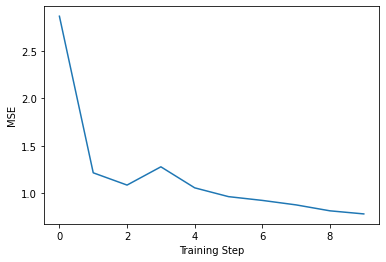

In [168]:
model = MLP(input_dim = 50 * 2, out_dim = 2, hidden_dim = 128).to(device)
model_austin, train_losses = train_city('austin', batch_size = 64, epochs = 10, model = model)
val_loss(model_austin, 'palo-alto', batch_size = 128)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 2.0470557536972533
epoch 1 trian loss: 1.0883665667318962
epoch 2 trian loss: 0.9253622187563186
epoch 3 trian loss: 0.8363222526129451
epoch 4 trian loss: 0.7691966565061764
epoch 5 trian loss: 0.7263603187079241
epoch 6 trian loss: 0.7110083936048801
epoch 7 trian loss: 0.7341257890311914
epoch 8 trian loss: 0.6703467151714003
epoch 9 trian loss: 0.6352218737235427
val loss: 0.2811772050331042


Text(0, 0.5, 'MSE')

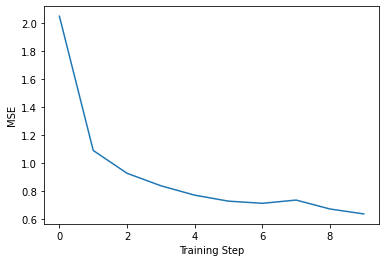

In [169]:
# miami
model = MLP(input_dim = 50 * 2, out_dim = 2, hidden_dim = 128).to(device)
model_miami, train_losses = train_city('miami', batch_size = 64, epochs = 10, model = model)
val_loss(model_miami, 'miami', batch_size = 128)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 2.1690129801514995
epoch 1 trian loss: 0.9402477156798402
epoch 2 trian loss: 0.8350628692839062
epoch 3 trian loss: 0.799889273510274
epoch 4 trian loss: 0.7355813686373609
epoch 5 trian loss: 0.7410316633299726
epoch 6 trian loss: 0.7915054155019638
epoch 7 trian loss: 0.7270612660266002
epoch 8 trian loss: 0.7186419346435897
epoch 9 trian loss: 0.8702286804696618
val loss: 0.536024764280295


Text(0, 0.5, 'MSE')

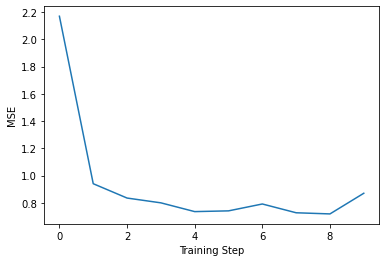

In [170]:
# pittsburgh
model = MLP(input_dim = 50 * 2, out_dim = 2, hidden_dim = 128).to(device)
model_pittsburgh, train_losses = train_city('pittsburgh', batch_size = 64, epochs = 10, model = model)
val_loss(model_pittsburgh, 'pittsburgh', batch_size = 128)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 5.81522767674004
epoch 1 trian loss: 1.7299841945847922
epoch 2 trian loss: 1.6025978237077825
epoch 3 trian loss: 1.5423355945774886
epoch 4 trian loss: 1.4180174933101253
epoch 5 trian loss: 1.3960420627321872
epoch 6 trian loss: 1.2940065180813978
epoch 7 trian loss: 1.2968182778429767
epoch 8 trian loss: 2.0649808114803094
epoch 9 trian loss: 1.328247612595172
val loss: 0.8122014847198781


Text(0, 0.5, 'MSE')

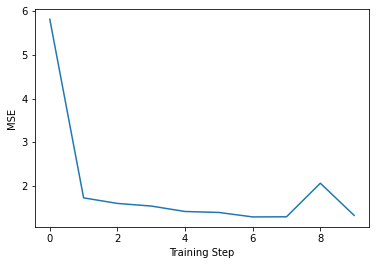

In [171]:
# dearborn
model = MLP(input_dim = 50 * 2, out_dim = 2, hidden_dim = 128).to(device)
model_dearborn, train_losses = train_city('dearborn', batch_size = 64, epochs = 10, model = model)
val_loss(model_dearborn, 'dearborn', batch_size = 128)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 3.777295188877205
epoch 1 trian loss: 1.1950847908103845
epoch 2 trian loss: 1.0445449941595981
epoch 3 trian loss: 0.9880757041942856
epoch 4 trian loss: 0.9256237491851452
epoch 5 trian loss: 1.1144526234000756
epoch 6 trian loss: 0.9073921217057862
epoch 7 trian loss: 1.0580835924441163
epoch 8 trian loss: 0.833569513577739
epoch 9 trian loss: 0.8213981314185745
val loss: 0.3880238363987624


Text(0, 0.5, 'MSE')

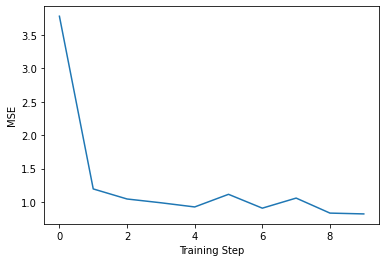

In [172]:
# washington_dc
model = MLP(input_dim = 50 * 2, out_dim = 2, hidden_dim = 128).to(device)
model_washington_dc, train_losses = train_city('washington-dc', batch_size = 64, epochs = 10, model = model)
val_loss(model_washington_dc, 'washington-dc', batch_size = 128)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 8.771202246329805
epoch 1 trian loss: 1.828631283255688
epoch 2 trian loss: 1.661601063533481
epoch 3 trian loss: 1.5865839748146697
epoch 4 trian loss: 1.4473817887705576
epoch 5 trian loss: 1.3333242607784102
epoch 6 trian loss: 1.3047087102299093
epoch 7 trian loss: 1.2391914750757769
epoch 8 trian loss: 6.52669028750086
epoch 9 trian loss: 2.019445602115295
val loss: 0.8152432068590643


Text(0, 0.5, 'MSE')

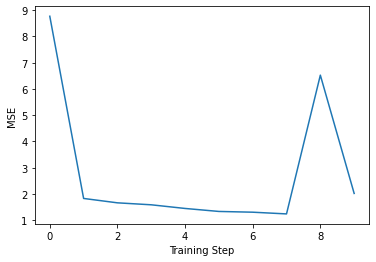

In [173]:
# palo_alto
model = MLP(input_dim = 50 * 2, out_dim = 2, hidden_dim = 128).to(device)
model_palo_alto, train_losses = train_city('palo-alto', batch_size = 64, epochs = 10, model = model)
val_loss(model_palo_alto, 'palo-alto', batch_size = 128)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

# Predictions

In [174]:
def predict_test(city, model):
    inp, out, traj_min, traj_max = get_city_trajectories(city = city, split = 'test')
    inp = torch.from_numpy(inp).float().cuda()
    preds = model(inp).detach().cpu()
    preds = (preds*(traj_max - traj_min) + traj_min)
    preds = preds.reshape(-1, 120)
    return pd.DataFrame(preds.numpy())

In [175]:
columns =['ID'] + ['v'+str(i) for i in range(120)]

In [176]:
def predict_all(cities, models):
    out = predict_test(cities[0], models[0]).reset_index()
    out.columns = columns
    out['ID'] = out['ID'].astype(str) + '_' + cities[0]
    
    for city, model in zip(cities[1:], models[1:]):
        temp = predict_test(city, model).reset_index()
        temp.columns = columns
        temp['ID'] = temp['ID'].astype(str) + '_' + city
        out = pd.concat([out, temp])
    
    return out      

In [177]:
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
models = [model_austin, model_miami, model_pittsburgh, model_dearborn, model_washington_dc, model_palo_alto]

In [178]:
test_output = predict_all(cities, models)

In [179]:
test_output

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,-18.483174,-565.190501,-18.280520,-565.605836,-18.315863,-565.823740,-18.295244,-565.989605,-18.200595,...,-52.086716,-557.409780,-52.595441,-557.250715,-52.920118,-557.103020,-53.347528,-557.009327,-53.913032,-556.924410
1,1_austin,-350.297148,14.313851,-349.812283,9.440074,-349.636170,7.225254,-349.122350,3.430935,-348.876695,...,-326.148724,-5.033401,-326.049463,-5.010304,-325.530108,-5.386739,-325.075928,-5.338213,-324.762148,-6.230987
2,2_austin,50.968272,-247.673349,50.968521,-247.675134,50.968613,-247.676415,50.968876,-247.678033,50.968722,...,51.062965,-247.716614,51.073058,-247.717261,51.084101,-247.717991,51.096484,-247.718318,51.111375,-247.718331
3,3_austin,-113.308020,1798.896407,-113.325300,1798.669847,-113.318641,1798.628981,-113.317562,1798.614262,-113.296754,...,-112.454245,1808.251298,-112.456072,1808.399844,-112.435381,1808.603560,-112.415828,1808.856309,-112.407931,1809.017774
4,4_austin,1201.277812,-645.152581,1201.043429,-645.180924,1201.437704,-645.094582,1201.555666,-645.453874,1202.452272,...,1269.354479,-666.739885,1271.257700,-667.683206,1272.681785,-668.666478,1274.650305,-669.726294,1276.496042,-670.733152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,1681_palo-alto,-1389.259796,-487.104760,-1390.407849,-487.807955,-1391.051657,-488.849020,-1391.554947,-489.834306,-1392.118177,...,-1423.735170,-527.627720,-1424.511544,-528.863793,-1425.321396,-530.068223,-1426.120670,-531.244658,-1426.890190,-532.357409
1682,1682_palo-alto,125.340963,-17.943387,125.349983,-18.079028,125.260680,-17.960211,125.077652,-16.793256,125.026790,...,120.520832,10.822428,120.446742,11.375818,120.368213,11.989814,120.296325,12.556826,120.231870,13.055999
1683,1683_palo-alto,-1442.649665,2164.772200,-1441.342628,2163.765948,-1440.695924,2163.300471,-1440.507265,2163.394747,-1439.577717,...,-1433.737409,2158.946643,-1433.724380,2158.913944,-1433.552952,2158.869367,-1433.560072,2158.836366,-1433.402067,2158.775847
1684,1684_palo-alto,1070.654198,1397.186773,1071.309030,1397.755529,1071.890315,1398.267055,1072.463372,1398.805713,1073.103058,...,1099.221528,1422.977806,1099.676534,1423.393705,1100.152285,1423.824715,1100.617888,1424.248744,1101.103917,1424.685968


In [182]:
test_output.to_csv('test_output.csv', index=False)

# Visualization

In [113]:
# intialize a dataset
def get_test_loader(city = 'palo-alto', batch_size = 1686):
    test_dataset  = ArgoverseDataset(city = city, split = 'test')
    val_dataset = None

    test_loader = DataLoader(train_dataset,batch_size=batch_size)
    val_loader = None
    return test_dataset, val_dataset, test_loader, val_loader

In [152]:
test_dataset, val_dataset, test_loader, val_loader = get_test_loader(city = 'palo-alto', batch_size = 1686)
for i_batch, sample_batch in enumerate(test_loader):
    inp, out, traj_min, traj_max = sample_batch
    inp = inp.float().cuda()
    preds = model_palo_alto(inp).detach().cpu()
    preds = (preds*(traj_max - traj_min) + traj_min).reshape(-1, 120)
    print(preds)
    break

tensor([[-1280.5506,  1175.2170, -1279.8432,  ...,  1248.6432, -1229.5693,
          1250.7270],
        [ -935.9139,  1024.8155,  -937.4941,  ...,  1069.2373,  -994.5708,
          1070.0721],
        [ -419.8502,  1411.4379,  -421.3496,  ...,  1459.8170,  -474.7168,
          1460.7670],
        ...,
        [ -708.8498,  2903.3897,  -708.8708,  ...,  2903.9451,  -709.4511,
          2903.9571],
        [-1459.6506,  1585.7798, -1461.9802,  ...,  1691.2205, -1544.0991,
          1693.2135],
        [-1507.1626,  -368.3078, -1505.9671,  ...,  -415.3984, -1448.5120,
          -415.8406]], dtype=torch.float64)


tensor([[[-1280.5506,  1175.2170],
         [-1279.8432,  1176.2554],
         [-1279.1180,  1177.2061],
         ...,
         [-1232.2311,  1246.6378],
         [-1230.9198,  1248.6432],
         [-1229.5693,  1250.7270]],

        [[ -935.9139,  1024.8155],
         [ -937.4941,  1025.6074],
         [ -939.5451,  1026.4471],
         ...,
         [ -993.1452,  1068.3906],
         [ -993.8514,  1069.2373],
         [ -994.5708,  1070.0721]],

        [[ -419.8502,  1411.4379],
         [ -421.3496,  1412.0213],
         [ -422.9484,  1412.6715],
         ...,
         [ -473.3061,  1458.8540],
         [ -474.0028,  1459.8170],
         [ -474.7168,  1460.7670]],

        ...,

        [[-2909.9004,  -311.2428],
         [-2911.6721,  -310.4449],
         [-2913.8706,  -309.6805],
         ...,
         [-2970.7725,  -277.7753],
         [-2971.5296,  -277.1419],
         [-2972.2933,  -276.5172]],

        [[  201.3107,   275.3993],
         [  201.3498,   275.3398],
         [  

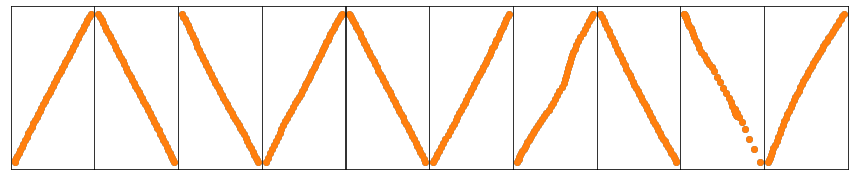

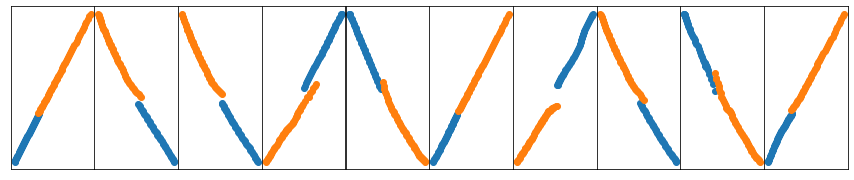

In [156]:
test_dataset, val_dataset, test_loader, val_loader = get_test_loader(city = 'palo-alto', batch_size = 1686)

import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(test_loader):
    inp, out, traj_min, traj_max = sample_batch
    inp = inp.float().cuda()
    preds = model_palo_alto(inp).detach().cpu()
    inp = inp.cpu()
    preds = (preds*(traj_max - traj_min) + traj_min)[:10,:,:]
    print(preds)
    #inp = inp.cpu()
    inp = (inp*(traj_max - traj_min) + traj_min)[:10,:,:]
    
    #print(global_std[0])
    #inverse_preds = pred*global_std[0] + global_mean[0]
    #inp = inp.cpu()*global_std[0] + global_mean[0]
    #out = out.cpu()*global_std[0] + global_mean[0]
    
    show_sample_batch([inp.cpu(), inp.cpu()])
    show_sample_batch([inp.cpu(), preds.cpu()])
    print(pred.shape)
    break

torch.Size([10, 60, 2])


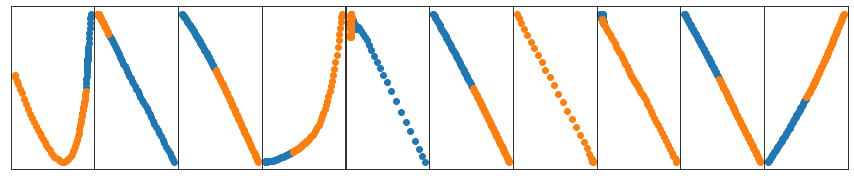

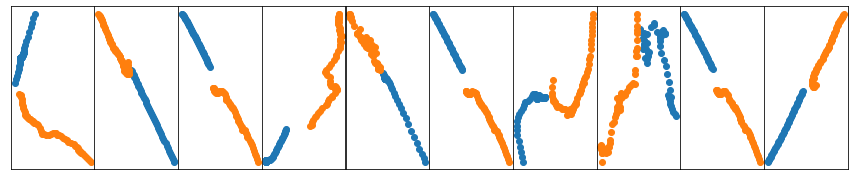

In [181]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 10)

import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(val_loader):
    if i_batch < 3: continue
    inp, out, global_mean, global_std = sample_batch
    inp = inp.float().cuda()
    out = out.float().cuda()
    
    pred = model_austin(inp).detach()
    #print(global_std[0])
    #inverse_preds = pred*global_std[0] + global_mean[0]
    #inp = inp.cpu()*global_std[0] + global_mean[0]
    #out = out.cpu()*global_std[0] + global_mean[0]
    
    show_sample_batch([inp.cpu(), out.cpu()])
    show_sample_batch([inp.cpu(), pred.cpu()])
    print(pred.shape)
    break